In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# FastAI Amalgam

> This library is a myriad collection of extensions for the `fastai` library. It has functionality for large scale visualisation, Grad-CAM, data augmentation with external libraries, loss functions, etc.

## Install

`pip install fastai_amalgam`

## Interpretation

##### `ClassificationInterpretationEx`

Extends fastai's [`ClassificationInterpretation`](https://github.com/fastai/fastai2/blob/master/fastai2/interpret.py#L48) to plot model confidence and per-label accuracy bar graphs. It also adds some convenience to grab filenames based on these confidence levels.

This part of the library is currently suitable for Softmax classifiers only. Multilabel support will be added soon.

In [ ]:
from fastai.vision.all import *
from fastai_amalgam.interpret.all import *

In [ ]:
#hide
from cinemanet.train.data_handler import *
from cinemanet.train.helpers import *

warnings.simplefilter('ignore')
dhandler = (
    DataHandler("../../CinemaNet-Training/exports/datasets/shot-framing.json",
                is_multilabel=False, verbose=False)
    .get_dataset_df('train-clean', 'valid-clean')
    .filter_dataset()
    .setup_dls(batch_size=32)
)

helper = ClassificationHelper(dhandler, '__', save_path="/tmp", antialiased=True)
learn  = helper.get_learner()
_learn = load_learner("../framing-1.pkl")
learn.model.load_state_dict(_learn.model.state_dict())

<All keys matched successfully>

In [ ]:
interp = ClassificationInterpretationEx.from_learner(learn)

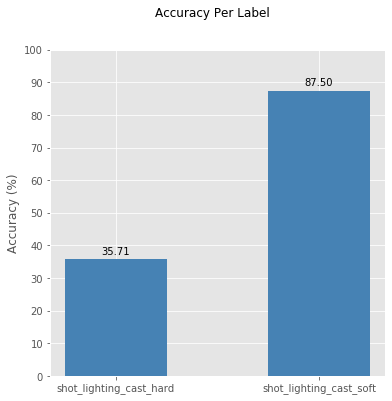

In [ ]:
plt.style.use('ggplot')
interp.plot_accuracy()

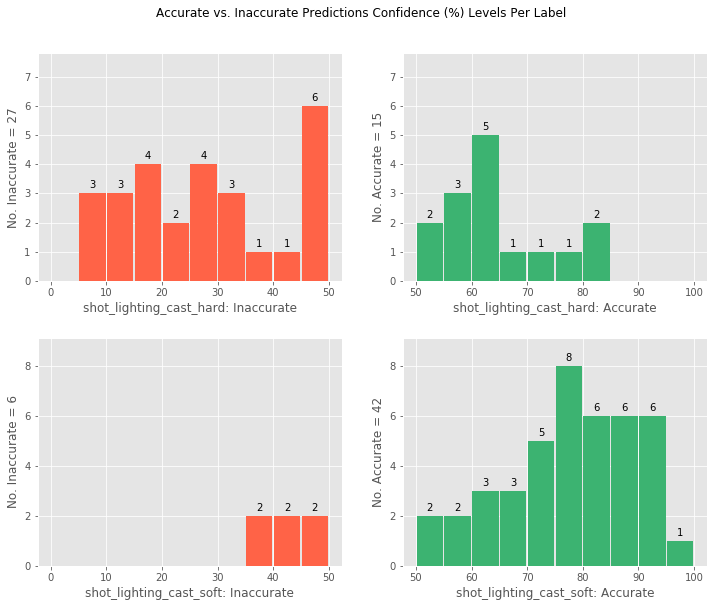

In [ ]:
interp.plot_label_confidence()

##### `GradCam`

The `GradCam` object takes in 3 args:
* `learn`: a fastai `Learner`
* `fname`: path to the image file to draw the heatcam over
* `labels`: list of labels to draw the heatmap for. If `None`, draws for the highest predicted class

There's quite a few plotting options. For more options, see the docs.

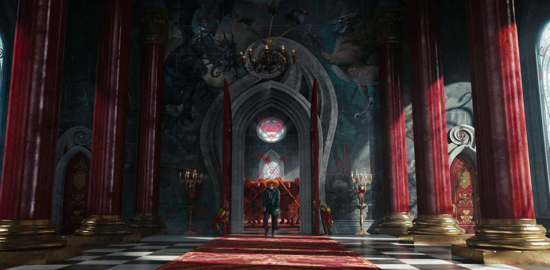

In [ ]:
import PIL
fname = '../assets/imgs/alice-in-wonderland.jpg'
PIL.Image.open(fname).resize((550,270))

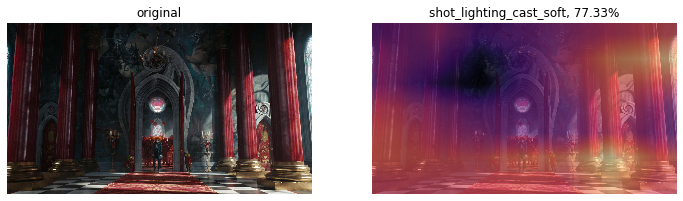

In [ ]:
gcam = GradCam(learn, fname, None)
gcam.plot(full_size=True, plot_original=True, figsize=(12,6))

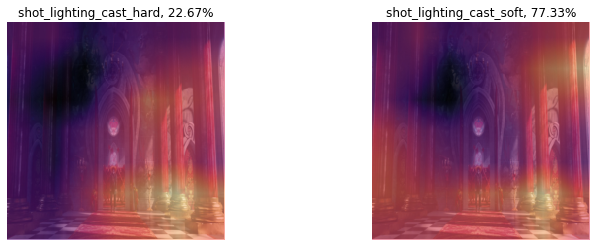

In [ ]:
gcam = GradCam(learn, fname, ['shot_lighting_cast_hard', 'shot_lighting_cast_soft'])
gcam.plot(full_size=False, plot_original=False, figsize=(12,4))

##### Comparing Multiple Models

`compare_venn` lets you compares 2 or models trained evaluated on the same dataset to inspect model agreement. If you only input 2 or 3 models, then you can also see Venn Diagrams for the same.

For simplicity, I'm using the same model here with smaller versions of the validation set to display this functionality.

In [ ]:
#hide
from torchvision.models import mobilenet_v2

path_data = Path('/Users/rahulsomani/Desktop/shot-lighting-cast')

dls1 = ImageDataLoaders.from_folder(path_data/'train', valid_pct=0.2, seed=42,
                                    item_tfms = Resize(size=224, method=ResizeMethod.Squish))
dls2 = ImageDataLoaders.from_folder(path_data/'train', valid_pct=0.15, seed=42,
                                    item_tfms = Resize(size=224, method=ResizeMethod.Squish))
dls3 = ImageDataLoaders.from_folder(path_data/'train', valid_pct=0.10, seed=42,
                                    item_tfms = Resize(size=224, method=ResizeMethod.Squish))



class ApplyPILFilter(RandTransform):pass
learn1 = load_learner(path_data/'fastai2-110-epoch-model.pkl');
learn1.dls = dls1

learn2 = load_learner(path_data/'fastai2-110-epoch-model.pkl');
learn2.dls = dls2

learn3 = load_learner(path_data/'fastai2-110-epoch-model.pkl');
learn3.dls = dls3

/Users/rahulsomani/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/rahulsomani/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/rahulsomani/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by 

In [ ]:
interp1 = ClassificationInterpretationEx.from_learner(learn1)
interp2 = ClassificationInterpretationEx.from_learner(learn2)
interp3 = ClassificationInterpretationEx.from_learner(learn3)
interp1.compute_label_confidence()
interp2.compute_label_confidence()
interp3.compute_label_confidence()

In [ ]:
%%capture
fig,common_labels = compare_venn(
    conf_level=(0,99),  interps=[interp1,interp2],
    mode='accurate',
    return_common=True, return_fig=True,
    set_color='tomato'
)

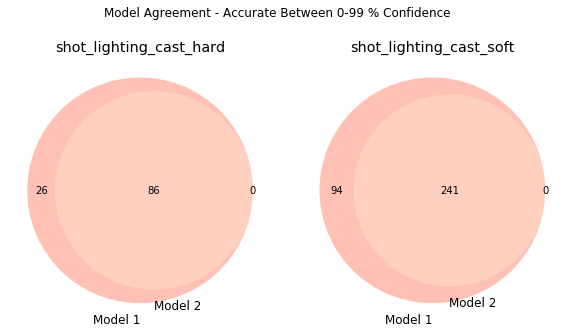

In [ ]:
fig

In [ ]:
%%capture
fig,common_labels = compare_venn(
    conf_level=(0,99),  interps=[interp1,interp2,interp3],
    mode='accurate',
    return_common=True, return_fig=True,
    set_color='tomato'
)

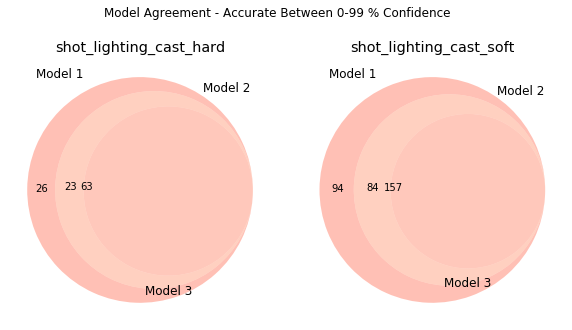

In [ ]:
fig

## Augmentation

`ApplyPILFilter`, not surprisingly, lets you apply one or more `PIL.ImageFilter`s as a data augmentation.

There's also a convenience function `read_lut` which lets you read in a LUT file (commonly found with `.cube` extensions), and construct a `PIL.ImageFilter.Color3dLUT` to apply as a transform.

The idea place for this in a fastai2 pipeline is as an `item_tfms` as it's a lossless transform and can be done right after reading the image from disk. A full example is shown in the docs.

In [ ]:
from fastai2_extensions.augment.pil_filters import *

In [ ]:
lut   = read_lut('../assets/luts/2strip.cube')
fname = '../assets/imgs/office-standoff.png'

img_raw  = PILImage.create(fname)
img_filt = ApplyPILFilter(lut,p=1.0)(fname, split_idx=0)

In [ ]:
%%capture
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
show_tensor = lambda x,ax: ToTensor()(x).show(ctx=ax)

show_tensor(img_raw,ax[0])
show_tensor(img_filt,ax[1])

ax[0].set_title('Original')
ax[1].set_title('LUT Transformed')

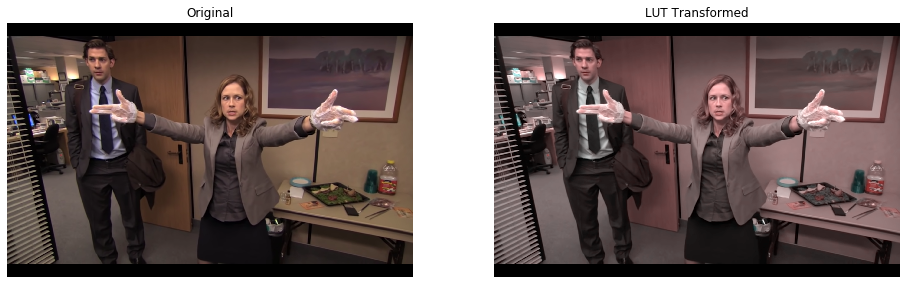

In [ ]:
fig

In [ ]:
from fastai2_extensions.augment.albumentations import *

`Tfms`, a list of 8 differnt kinds of transforms, is imported into the namespace. This is a list of albumentation transforms, with no relation to `fastai`.

`AlbumentationsWrapper` is a wrapper for any `albumentations.Compose` object, that can be passed into a `DataBlock` object in the list of `item_tfms`

In [ ]:
ColorTonesTfms

OneOf([
  ToSepia(always_apply=False, p=0.5),
  ToGray(always_apply=False, p=0.5),
], p=0.3)

In [ ]:
ColorTonesTfms.p = 1.0
color_tfms = AlbumentationsWrapper(ColorTonesTfms)

In [ ]:
img = PILImage.create(fname)
aug_img = color_tfms(fname)

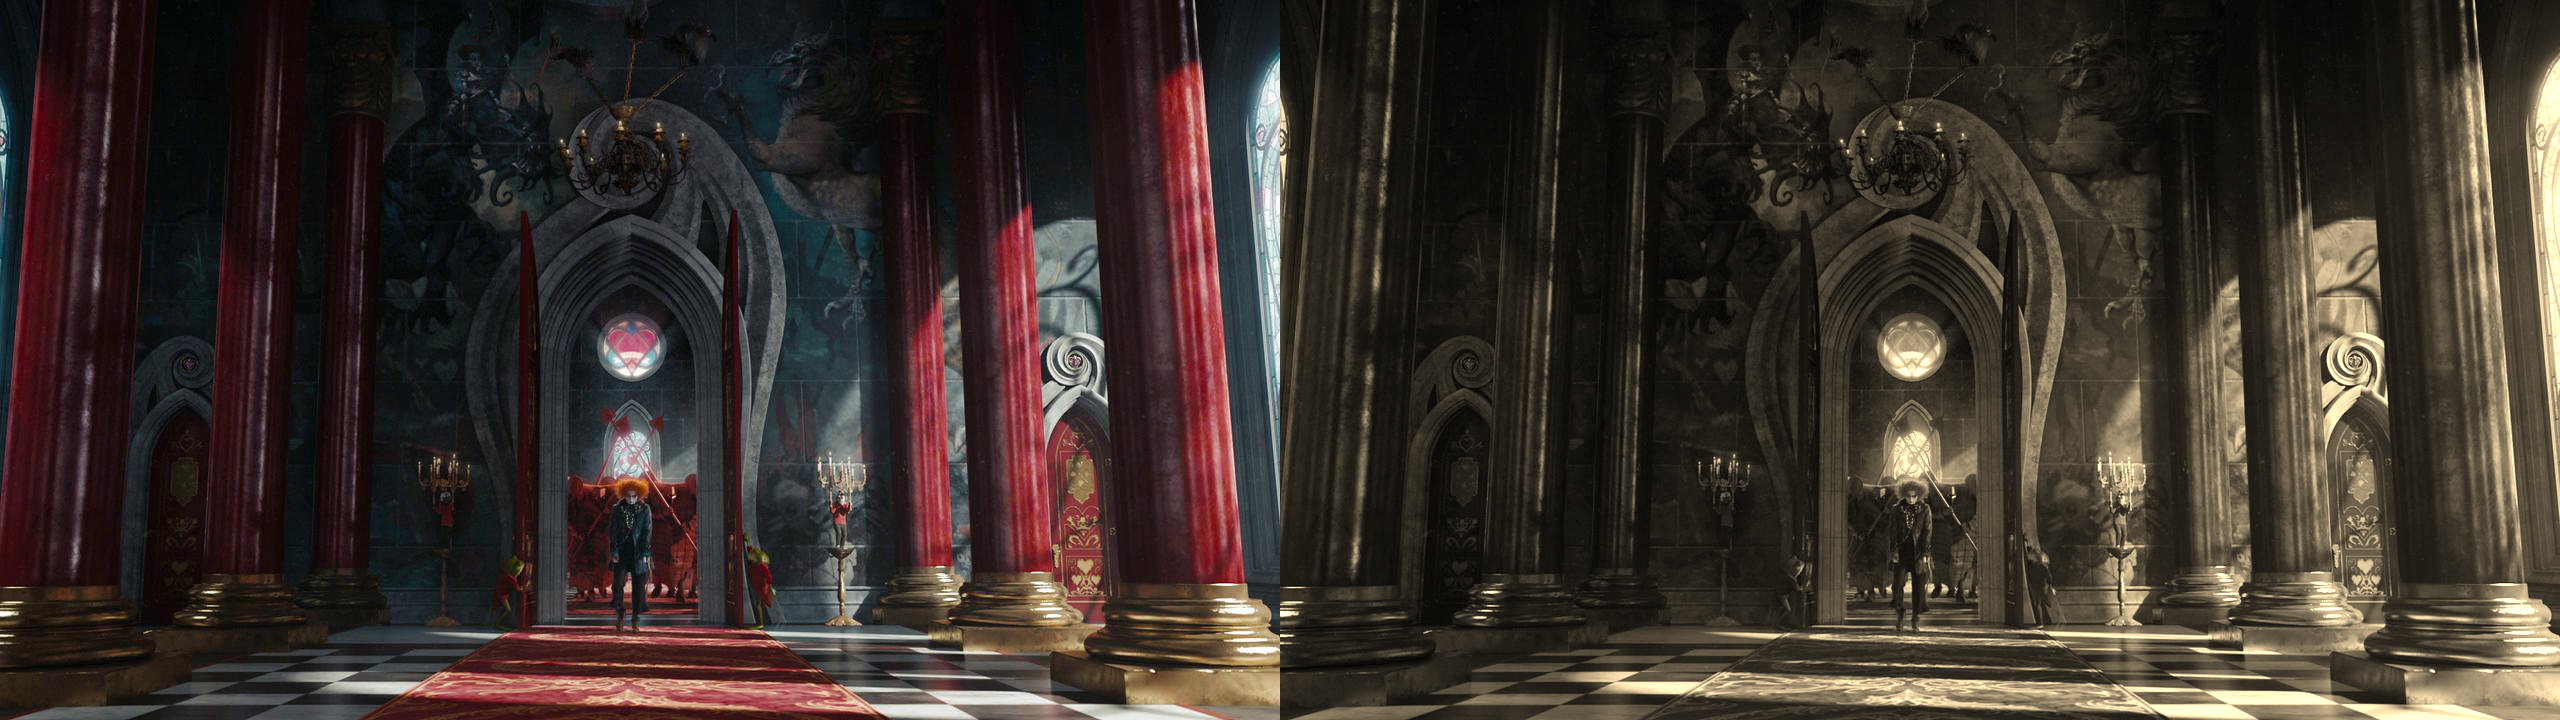

In [ ]:
hstack = np.hstack( (np.array(img), np.array(aug_img)) )
PIL.Image.fromarray(hstack)

## Export

Convenience wrappers to export to `ONNX`. <br>
Other frameworks will be added soon.

##### ONNX

In [ ]:
#hide_output
from fastai2_extensions.inference.export import *

In [ ]:
torch_to_onnx(learn.model,
              activation   = nn.Softmax(-1),
              save_path    = Path.home()/'Desktop',
              model_fname  = 'onnx-model',
              input_shape  = (1,3,224,224),
              input_name   = 'input_image',
              output_names = 'output')

Loading, polishing, and optimising exported model from /Users/rahulsomani/Desktop/onnx-model.onnx
Exported successfully


In [ ]:
path_onnx_model = '/Users/rahulsomani/Desktop/onnx-model.onnx'
fname = '../assets/imgs/odyssey-ape.png'

In [ ]:
from onnxruntime import InferenceSession

session = InferenceSession(path_onnx_model)
x = {session.get_inputs()[0].name:
     torch_to_numpy(preprocess_one(fname))} # preprocessing - varies based on your training
session.run(None, x)

[array([[0.6942669 , 0.30573303]], dtype=float32)]